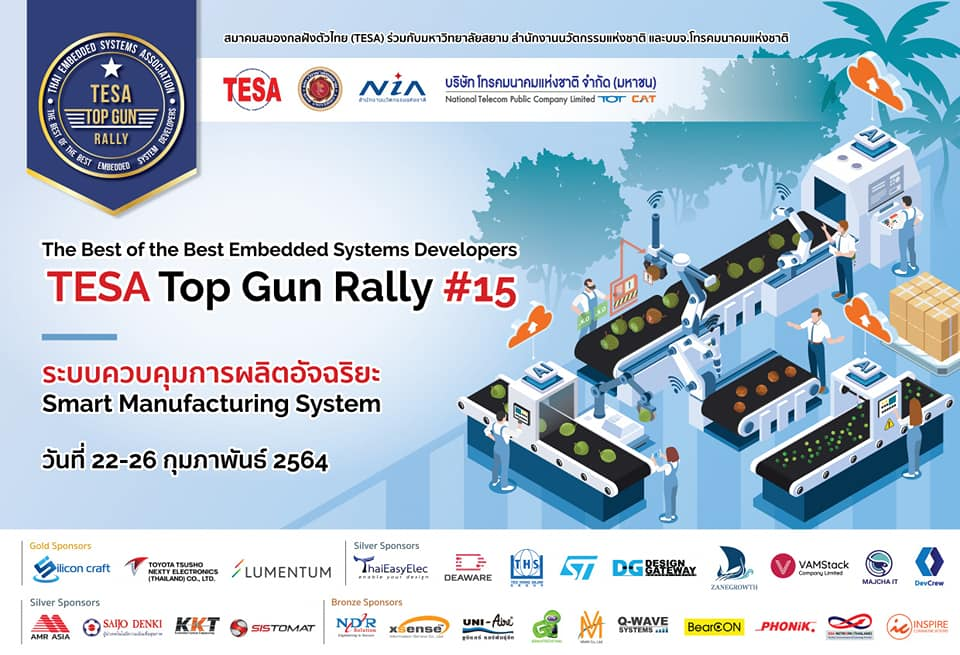

# Step 1: prepare dataset (offline)

## 1.1 Get video files

## 1.2 Prepare images using OpenCV

## 1.3 Prepare labelImg
1. install required packages: `pip install PyQt5 lxml`
1. clone labelImg repository: `git clone https://github.com/tzutalin/labelImg`
1. move into folder: `cd labelImg`
1. build labelImg: `pyrcc5 -o libs/resources.py resources.qrc`
1. run labelImg: `python labelImg.py`
1. click **Open Dir** and set **Save Dir**
1. use 'a' to previous, 'd' to next, 'w' to start rect

## 1.4 upload to Google Drive
* **data/train/** folder for image and xml files
* **data/test/** folder for image and xml files
* **data/annotations.json** for class definition

# Step 2: prepare dataset

## 2.1 mount Google Drive

In [ ]:
#2.1 Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')
try:
  os.mkdir('/content/drive/My Drive/TGR-2021')  
  os.chdir('/content/drive/My Drive/TGR-2021/')
except:
  os.chdir('/content/drive/My Drive/TGR-2021')

# folders and files definition
train_images_folder = 'data/train/'
test_images_folder = 'data/test/'
annotation_file = 'data/annotations.json'

Mounted at /content/drive


## 2.2 convert data files

In [ ]:
#2.2 convert data files
import cv2
import json
import glob
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from six import BytesIO
from PIL import Image

def load_image_into_numpy_array(img_file):
  return cv2.imread(img_file)

# import class definition from JSON
with open(annotation_file) as f:
  classes_dict = json.load(f)
  num_classes = len(classes_dict)
  
train_images_np = []
classes_np = []
gt_boxes = []
for img_file in glob.glob(train_images_folder + '*.jpg'):
  # import image as numpy array
  train_images_np.append( load_image_into_numpy_array(img_file) )
  # import XML as numpy array
  xml_file = img_file.replace('.jpg', '.xml')
  tree = ET.parse(xml_file)
  root = tree.getroot()
  width = int(root.find('size')[0].text)
  height = int(root.find('size')[1].text)
  classes = []
  bbox = []
  for member in root.findall('object'):
    classes.append(classes_dict[member[0].text] - 1)
    bbox.append([
        float(member[4][1].text)/height,
        float(member[4][0].text)/width,
        float(member[4][3].text)/height,
        float(member[4][2].text)/width
    ])
  classes_np.append(np.array(classes, dtype=np.int32))
  gt_boxes.append(np.array(bbox, dtype=np.float32))

In [ ]:
classes_np

[array([1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32)]

In [ ]:
# convery list of numpy arrays to tensor
num_classes = len(classes_dict)
train_image_tensors = []
gt_box_tensors = []
gt_classes_one_hot_tensors = []
for (train_image_np, gt_box_np, class_np) in zip(train_images_np, gt_boxes, classes_np):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np)
  gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [ ]:
gt_classes_one_hot_tensors

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf

# Step 3: train model

## 3.1 prepare TensorFlow Object Detection API

In [ ]:
#3.1 prepare TensorFlow Object Detection API
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2428, done.
remote: Counting objects: 100% (2428/2428), done.
remote: Compressing objects: 100% (2025/2025), done.
remote: Total 2428 (delta 585), reused 1382 (delta 375), pack-reused 0
Receiving objects: 100% (2428/2428), 30.79 MiB | 17.76 MiB/s, done.
Resolving deltas: 100% (585/585), done.
Checking out files: 100% (2263/2263), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/drive/My Drive/TGR-2021/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1619135 sha256=ee62712ecb998ffe2cddd282cf244bdb7e3ecc2b2b9c3c387fc5c9c3c530ff8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-8p4fyfkx/wheels/ad/10/ae/04a985dbcdc9b0c3724cea45adcbb0870d550d979d6acb126b
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


## 3.2 download and prepare model

In [ ]:
# 3.2 download and prepare model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-02-23 01:08:24--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.2.112, 2607:f8b0:4004:80a::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.2.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.4’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  83.7MB/s    in 0.2s    

2021-02-23 01:08:24 (83.7 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.4’ saved [20515344/20515344]



In [ ]:
# import libraries
import matplotlib
import matplotlib.pyplot as plt
import random

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# model definition
model_dim = 320

[[0.555   0.475   0.73625 0.67   ]]
0


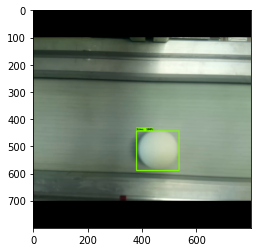

In [ ]:
category_index = {1: {'id': 1, 'name': 'lime'}, 2: {'id': 2, 'name': 'marker'},}
dummy_scores = np.array([1],dtype=np.float32)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  image_np_with_annotations = cv2.cvtColor(image_np.copy(), cv2.COLOR_BGR2RGB)
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

idx = 0
print(gt_boxes[idx])
print(class_np[idx])
plot_detections(
    train_images_np[idx],
    gt_boxes[idx],
    np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
    dummy_scores, 
    category_index)

## 3.3 train model

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.post_processing.batch_non_max_suppression.max_detections_per_class = 10
model_config.ssd.post_processing.batch_non_max_suppression.max_total_detections = 10
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

# Set up object-based checkpoint restore
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    #_prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, model_dim, model_dim, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
# 3.3 train model
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned
batch_size = 5
learning_rate = 0.15
num_batches = 200

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    shapes = tf.constant(batch_size * [[model_dim, model_dim, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 5 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 200, loss=0.09576233
batch 5 of 200, loss=0.09483788
batch 10 of 200, loss=0.06709904
batch 15 of 200, loss=0.08396453
batch 20 of 200, loss=0.058325812
batch 25 of 200, loss=0.09201999
batch 30 of 200, loss=0.06014785
batch 35 of 200, loss=0.102788515
batch 40 of 200, loss=0.06899675
batch 45 of 200, loss=0.07408768
batch 50 of 200, loss=0.08460414
batch 55 of 200, loss=0.094100356
batch 60 of 200, loss=0.09660464
batch 65 of 200, loss=0.11543453
batch 70 of 200, loss=0.07277977
batch 75 of 200, loss=0.10559796
batch 80 of 200, loss=0.069541395
batch 85 of 200, loss=0.09280321
batch 90 of 200, loss=0.056626134
batch 95 of 200, loss=0.12268529
batch 100 of 200, loss=0.1029058
batch 105 of 200, loss=0.07085003
batch 110 of 200, loss=0.082624055
batch 115 of 200, loss=0.05104164
batch 120 of 200, loss=0.060121246
batch 125 of 200, loss=0.097174615
batch 130 of 200, loss=0.09993552
batch 135 of 200, loss=0.087991476
batch 140 of 200, loss=0.056084856
batch 145 of 200, loss=0.14

## 3.4 preview result

[2] [[0.5546299  0.4740855  0.73607457 0.6717567 ]]
[2] [[0.5354239 0.5517034 0.7134417 0.7461068]]
[2] [[0.39723203 0.5707618  0.5779748  0.7664033 ]]
[1] [[0.40300512 0.56160194 0.57995003 0.7532663 ]]
[1] [[0.50372905 0.5054337  0.6926361  0.70145404]]
[1] [[0.36679378 0.63517404 0.5610657  0.8421011 ]]
[1] [[0.45000187 0.6557466  0.6433158  0.86227655]]
[1] [[0.5090299  0.63950086 0.7111824  0.8602334 ]]
[1] [[0.4211328 0.6521854 0.6145879 0.859356 ]]
[1] [[0.39664182 0.58897215 0.5886198  0.79176074]]
[1] [[0.44000965 0.5938318  0.6279823  0.7962259 ]]
[1] [[0.45554674 0.70801675 0.6480452  0.91127884]]
[1] [[0.505417   0.47415903 0.6935761  0.67278254]]
[1] [[0.44231784 0.5877732  0.6298113  0.7801882 ]]
[1] [[0.45147577 0.6593214  0.64693594 0.86708593]]
[1] [[0.41731247 0.637738   0.6059187  0.8447211 ]]
[1] [[0.46628118 0.55070645 0.65658796 0.75357646]]
[1] [[0.46241584 0.6848068  0.64880335 0.89448047]]
[1] [[0.42405248 0.5729407  0.60876346 0.7710351 ]]
[1] [[0.39762324 0.6

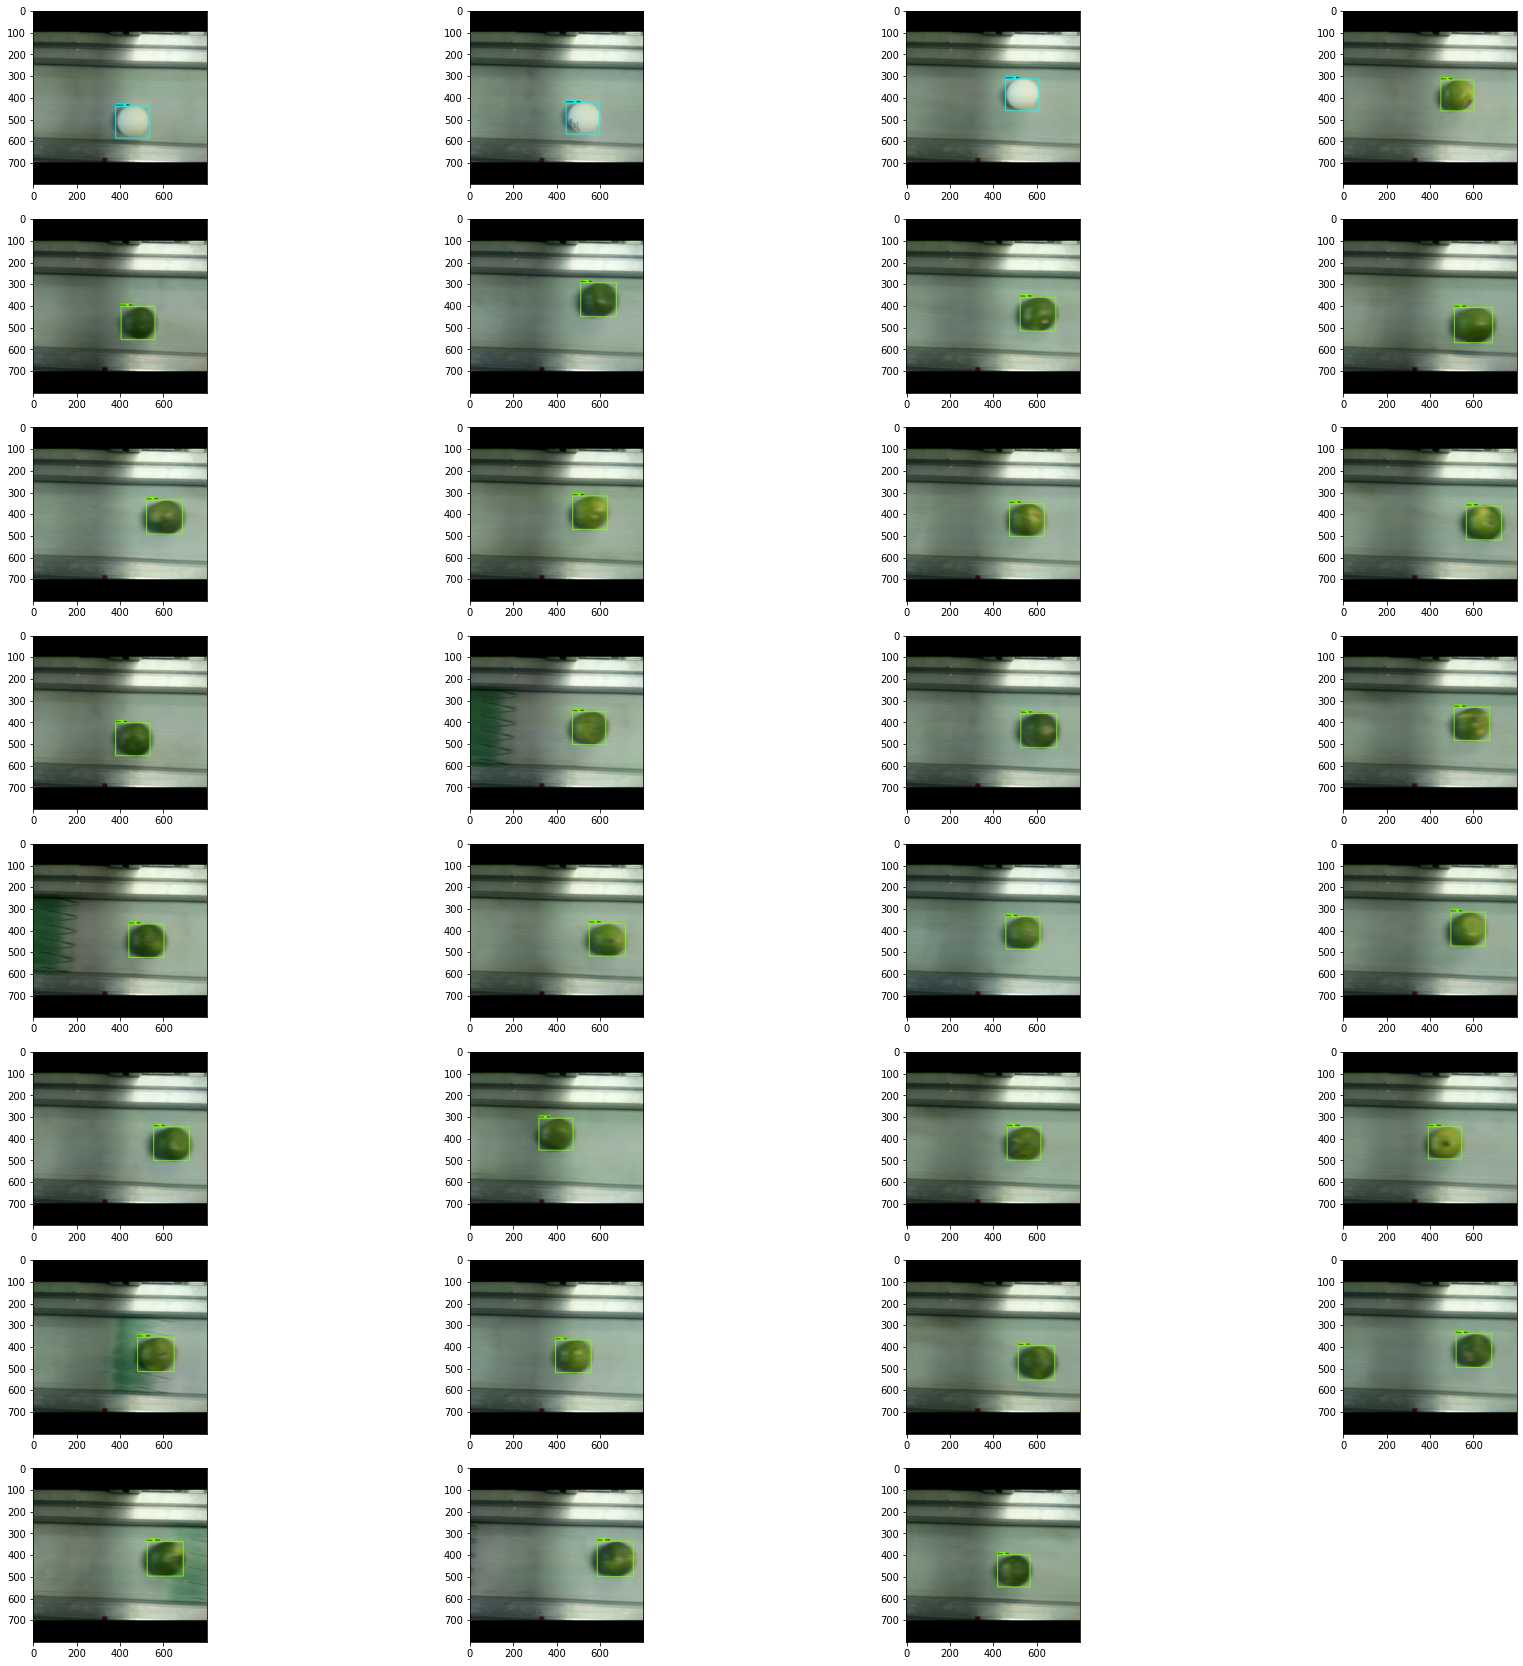

In [ ]:
# 3.4 preview
category_index = {1: {'id': 1, 'name': 'lime'}, 2: {'id': 2, 'name': 'marker'},}

@tf.function
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

test_images_np = []
for img_file in glob.glob(test_images_folder + '*.jpg'):
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(img_file), axis=0))

plt.figure(figsize=(30, 30))
for idx in range(len(test_images_np)):
  plt.subplot(len(test_images_np)//4+1, 4, idx+1)
  input_tensor = tf.convert_to_tensor(test_images_np[idx], dtype=tf.float32)
  detections = detect(input_tensor)
  plot_detections(
      test_images_np[idx][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + 1,
      detections['detection_scores'][0].numpy(),
      category_index)
  bboxes = detections['detection_boxes'][0].numpy()
  classes = detections['detection_classes'][0].numpy().astype(np.uint32) + 1
  scores = detections['detection_scores'][0].numpy()
  print(classes[scores > 0.8], bboxes[scores > 0.8])

In [ ]:
bboxes

array([[0.4990131 , 0.52570534, 0.6830987 , 0.7136251 ],
       [0.52975434, 0.5748362 , 0.652729  , 0.6573495 ],
       [0.5573073 , 0.5601392 , 0.65729564, 0.683777  ],
       [0.        , 0.03434719, 0.13736983, 0.20964928],
       [0.5001211 , 0.5210817 , 0.6874075 , 0.71521866],
       [0.48312297, 0.5384971 , 0.69456404, 0.8297541 ],
       [0.5237363 , 0.5800705 , 0.6287561 , 0.69249475],
       [0.5474472 , 0.5530703 , 0.6569452 , 0.6313188 ],
       [0.25648463, 0.12078851, 0.9337325 , 0.88362867],
       [0.63159347, 0.49300644, 0.717945  , 0.71433765]], dtype=float32)

In [ ]:
scores

array([0.98066264, 0.1208997 , 0.09832456, 0.08580145, 0.08138783,
       0.06677888, 0.06409512, 0.04997231, 0.0458756 , 0.04245988],
      dtype=float32)

# Step 4: export model

In [ ]:
# Save new pipeline config
output_pipeline_path = 'output/'
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_pipeline_path)

# export checkpoint
output_checkpoint_path = 'output/checkpoints/'
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_path, max_to_keep=1)
ckpt_manager.save()

INFO:tensorflow:Writing pipeline config file to output/pipeline.config


'output/checkpoints/ckpt-1'